In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [45]:
import imp

import pumpp
import pickle
import keras as K
import numpy as np

import pandas as pd
from tqdm import tqdm_notebook as tqdm

import json
import jams
import sklearn.metrics as skm

In [61]:
import matplotlib.pyplot as plt
%matplotlib nbagg
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
with open('/home/bmcfee/git/chord_models/data/pump.pkl', 'rb') as fd:
    pump = pickle.load(fd)

In [7]:
model_cr1 = imp.load_source('train_model', '/home/bmcfee/git/chord_models/code/train_model.py')

In [8]:
model_cr2 = imp.load_source('train_deep', '/home/bmcfee/git/chord_models/code/train_deep.py')

In [12]:
WORKING = '/home/bmcfee/working/chords/'

In [13]:
AUGMENTATION = True
WEIGHTED = False

In [36]:
model_cr1.make_output_path(WORKING, True, AUGMENTATION, WEIGHTED)

'/home/bmcfee/working/chords/model_struct_aug'

In [ ]:
# Load model weights for fold -- needs model, split id, output path
# Load test index for fold -- needs split id
# Iterate over points -- needs split id
#    accumulate confusions

In [16]:
# First, CR1

In [26]:
def load_datum(test_id):
    return np.load(os.path.join(WORKING, 'pump', '{}.npz'.format(test_id)))

In [120]:
def confusion(model, test_id, pump, structured):
    x = load_datum(test_id)
    
    ytrue = x['chord_tag/chord'][0].squeeze()
    
    if structured:
        ypred = model.predict(x['cqt/mag'])[0][0].argmax(axis=1)
    else:
        ypred = model.predict(x['cqt/mag'])[0].argmax(axis=1)
    
    n = min(len(ypred), len(ytrue))
    return skm.confusion_matrix(ytrue[:n], ypred[:n],
                                labels=range(len(pump['chord_tag'].encoder.classes_)))

In [162]:
# Build the model
def confuse_split(split, structured, pump, model_class):

    # Locate the weights
    path = model_class.make_output_path(WORKING, structured, AUGMENTATION, WEIGHTED)
    
    conf_file = os.path.join(path, 'fold{:02d}_confusion.pkl'.format(split))
    
    if os.path.exists(conf_file):
        C = pickle.load(open(conf_file, 'rb'))
        return np.sum(C, axis=0)
    
    
    model = model_class.construct_model(pump, structured)[0]

    

    weight_path = os.path.join(path, 'fold{:02d}_weights.pkl'.format(split))
    model.load_weights(weight_path)

    # Load the test index
    test_idx = pd.read_csv(os.path.join(WORKING, 'test{:02d}.csv'.format(split)), header=None)[0]

    vocab = pump['chord_tag'].encoder.classes_

    C = [confusion(model, test_id, pump, structured) for test_id in tqdm(test_idx)]
    
    # Save the confusion matrices
    with open(os.path.join(path, 'fold{:02d}_confusion.pkl'.format(split)), 'wb') as fd:
        pickle.dump(C, fd)
        
    Ctotal = np.sum(C, axis=0)
    
    return Ctotal

In [163]:
# CR2
C_CR2 = []
for split in tqdm(range(5)):
    C_CR2.append(confuse_split(split, False, pump, model_cr2))

In [176]:
# CR2S
C_CR2S = []
for split in tqdm(range(5)):
    C_CR2S.append(confuse_split(split, True, pump, model_cr2))

In [185]:
# Can we aggregate down to root confusion and quality confusion?

def conf_to_qconf(C):
    
    # Qualities = 14 + 2
    
    Q = np.zeros((16, 16), dtype=C.dtype)
    
    for i in range(0, 12):
        Q[:14, :14] += C[i * 12: i * 12 + 14,
                       i * 12: i * 12 + 14]
        
        Q[:14, 14:] += C[i * 12:i * 12 + 14, -2:]
        Q[14:, :14] += C[-2:, i * 12:i * 12 + 14]
        
    return Q

In [214]:
T_CR2 = np.sum(C_CR2, axis=0)

In [215]:
T_CR2.diagonal().sum() / T_CR2.sum()

0.62832989966265018

In [211]:
T_CR2s = np.sum(C_CR2S, axis=0)

In [213]:
T_CR2s.diagonal().sum() / T_CR2s.sum()

0.63603440597497185

In [216]:
T_CR2s.diagonal().sum() / T_CR2s.sum() - T_CR2.diagonal().sum() / T_CR2.sum()

0.0077045063123216684

In [217]:
def norm(x, axis=1):
    return x / x.sum(axis=axis, keepdims=True)

In [218]:
Q_CR2 = conf_to_qconf(np.sum(C_CR2, axis=0))

In [219]:
Q_CR2S = conf_to_qconf(np.sum(C_CR2S, axis=0))

In [220]:
vocab = pump['chord_tag'].encoder.inverse_transform(np.arange(170))

In [221]:
qvocab = [s[s.index(':')+1:] for s in vocab[:14]] + ['N', 'X']

In [229]:
SAVE = True

<IPython.core.display.Javascript object>


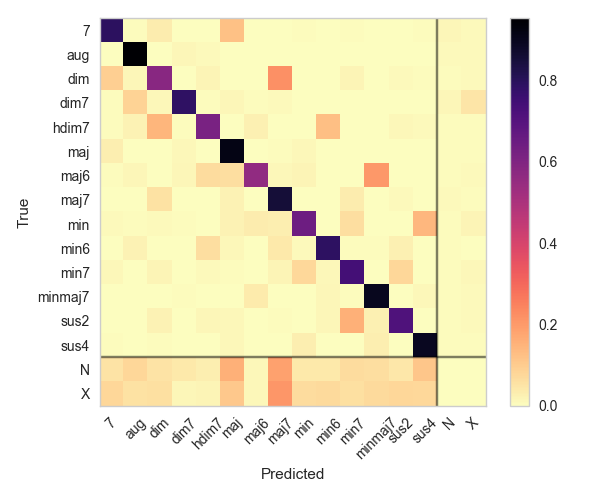

In [232]:
plt.figure(figsize=(6,5))

mesh = plt.pcolormesh(norm(Q_CR2S), cmap='magma_r')
plt.grid('off')
plt.axvline(14, color='k', alpha=0.5)
plt.axhline(14, color='k', alpha=0.5)
plt.xticks(np.arange(0.5, 16+0.5), qvocab, rotation=45)
plt.yticks(np.arange(0.5, 16+0.5), qvocab)
plt.gca().invert_yaxis()
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.title('Quality confusions: CR2+S+A')
plt.colorbar()
plt.tight_layout()
mesh.set_rasterized(True)

if SAVE:
    plt.savefig('../paper/figs/qualconf.pdf', transparent=True, pad_inches=0)
    !convert ../paper/figs/qualconf.pdf ../paper/figs/qualconf.eps

<IPython.core.display.Javascript object>


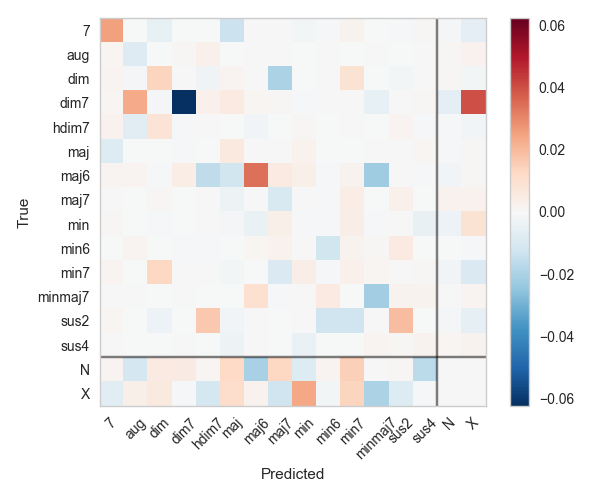

In [233]:
plt.figure(figsize=(6,5))

delta = norm(Q_CR2S) - norm(Q_CR2)

mesh = plt.pcolormesh(delta, cmap='RdBu_r', vmin=-np.max(np.abs(delta)), vmax=np.max(np.abs(delta)))
plt.grid('off')
plt.axvline(14, color='k', alpha=0.5)
plt.axhline(14, color='k', alpha=0.5)
plt.xticks(np.arange(0.5, 16+0.5), qvocab, rotation=45)
plt.yticks(np.arange(0.5, 16+0.5), qvocab)
plt.gca().invert_yaxis()
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.title('Structured - Unstructured')
plt.colorbar()
plt.tight_layout()
mesh.set_rasterized(True)

if SAVE:
    plt.savefig('../paper/figs/confdelta.pdf', transparent=True, pad_inches=0)
    !convert ../paper/figs/confdelta.pdf ../paper/figs/confdelta.eps

In [205]:
(2 * delta.diagonal().sum() - delta.sum())

20434